In [829]:
import requests
import psycopg2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import roc_curve, auc
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall


In [866]:
# Define protein of interest and minimum interaction score
protein_of_interest = "BRCA1"
min_interaction_score = 0.6

In [867]:
# Map the dictionary of collected GO terms to pretrained hig2vec embeddings
# https://academic.oup.com/bioinformatics/article/37/18/2971/6184857

# Load pretrained hig2vec model for GO word embedding / vector conversion
model = torch.load("hig2vec_human_200dim.pth", map_location="cpu")
objects, embeddings = model['objects'], model['embeddings']

In [868]:
# Filter out duplicate interactions  e.g.: (A - B, B - A), keep only desired fields
def filter_interactions(data):
    unique_pairs = set()
    filtered_data = []

    for entry in data:
        pair = (entry['stringId_A'], entry['stringId_B'])
        if entry["score"] < min_interaction_score:
            continue
        if pair not in unique_pairs and pair[::-1] not in unique_pairs:
            unique_pairs.add(pair)
            filtered_data.append({
                "stringId": entry["stringId_B"],
                "preferredName": entry["preferredName_B"],
                "score": entry["score"],
                "nscore": entry["nscore"],
                "fscore": entry["fscore"],
                "pscore": entry["pscore"],
                "ascore": entry["ascore"],
                "escore": entry["escore"],
                "dscore": entry["dscore"],
                "tscore": entry["tscore"]
            })

    filtered_data = sorted(filtered_data, key=lambda x: x["score"], reverse=True)
    return filtered_data

In [869]:
# Retrieve the interaction partners with the protein of interest from STRING
def retrieve_interaction_partners(protein_name):
    # Optionally map the protein name to STRING ID
    # mapping_identifiers_url = f"https://string-db.org/api/json/get_string_ids?identifiers={protein_name}&species=9606"
    # res = requests.get(mapping_identifiers_url)
    
    url = f'https://string-db.org/api/json//interaction_partners?identifiers={protein_name}&species=9606&limit=10000'
    response = requests.get(url)
    if response.status_code == 200:
        print(f"Fetched {len(response.json())} number of interaction partners for {protein_name}")
        json_data_filtered = filter_interactions(response.json())
        print(f"Number of interactions after filtering {len(json_data_filtered)}")
        return json_data_filtered
    else:
        print('Request to retrieve interaction partners failed with status code:', response.status_code, 'response text:', response.text)

In [870]:
def get_protein_features(string_ids, is_interacting):
    GO_dictionary = {}
    pagination_size = 100
    
    for i in range(len(string_ids)):
        if i * pagination_size > len(string_ids):
            break
        temp_prot_feature_url = f'https://string-db.org/api/json/functional_annotation?species=9606&identifiers={"%0d".join(map(str, string_ids[i*pagination_size:i*pagination_size+pagination_size]))}'
        res = requests.get(temp_prot_feature_url)
        print(f'Retrieving Gene Ontology terms for {"interaction" if is_interacting else "non-interaction"} parters: {i * pagination_size} - {i * pagination_size + pagination_size}')
        if res.status_code == 200:
            data = res.json()
            for item in data:
                if not item["term"].startswith("GO:"):
                    continue  # Skip if the term doesn't start with "GO:"
                if len(item["inputGenes"]) > 1:
                    continue  # Skip if there is more than one gene in the inputGenes list
                input = f'{item["inputGenes"][0]}'
                # Can either be Process, Component, Function
                input_term_type = f'{item["category"]}'
                if input in GO_dictionary:
                    GO_dictionary[input]["associated_GO_terms"][input_term_type].append(item["term"])
                else:
                    GO_dictionary[input] = {
                        "preferredName": item["preferredNames"][0],
                        "associated_GO_terms": {
                            'Process': [], 
                            'Component': [],
                            'Function': []
                        },
                        "is_interacting": is_interacting
                    }
                    GO_dictionary[input]["associated_GO_terms"][input_term_type].append(item["term"])

    print(f"Original length: {len(GO_dictionary)}.")
    
    filtered_dictionary = {}
    for key, value in GO_dictionary.items():
        associated_GO_terms = value.get('associated_GO_terms', {})
        process_terms = associated_GO_terms.get('Process', [])
        component_terms = associated_GO_terms.get('Component', [])
        function_terms = associated_GO_terms.get('Function', [])
    
        # Check if process and function are present
        if process_terms and function_terms:
            filtered_dictionary[key] = value
            
    print(f"Go term filtered protein list length: {len(filtered_dictionary)}.")
    return filtered_dictionary

In [871]:
def map_go_terms_to_tensors(protein_features):
    total_num_of_tensors_retrieved = 0
    total_num_of_string_ids = 0

    for string_id in protein_features:
        total_num_of_string_ids += 1
        go_term_processes = protein_features[string_id]["associated_GO_terms"]["Process"]
        go_term_components = protein_features[string_id]["associated_GO_terms"]["Component"]
        go_term_functions = protein_features[string_id]["associated_GO_terms"]["Function"]
        for go_function in go_term_functions:
            if go_function not in objects:
                continue
            go_index = objects.index(go_function)
            go_embedding = embeddings[go_index]
            total_num_of_tensors_retrieved += 1
            # Returns a torch.float64 tensor - vector - of dimension 200

            if "GO_function_embeddings" in protein_features[string_id]:
                protein_features[string_id]["GO_function_embeddings"].append(go_embedding)
            else:
                protein_features[string_id]["GO_function_embeddings"] = [go_embedding]
        for go_component in go_term_components:
            if go_component not in objects:
                continue
            go_index = objects.index(go_component)
            go_embedding = embeddings[go_index]
            total_num_of_tensors_retrieved += 1
            # Returns a torch.float64 tensor - vector - of dimension 200

            if "GO_component_embeddings" in protein_features[string_id]:
                protein_features[string_id]["GO_component_embeddings"].append(go_embedding)
            else:
                protein_features[string_id]["GO_component_embeddings"] = [go_embedding]
        for go_process in go_term_processes:
            if go_process not in objects:
                continue
            go_index = objects.index(go_process)
            go_embedding = embeddings[go_index]
            total_num_of_tensors_retrieved += 1
            # Returns a torch.float64 tensor - vector - of dimension 200

            if "GO_process_embeddings" in protein_features[string_id]:
                protein_features[string_id]["GO_process_embeddings"].append(go_embedding)
            else:
                protein_features[string_id]["GO_process_embeddings"] = [go_embedding]


    # filter protein_features to only include proteins where there is at least one valid process embedding and one valid function embedding
    print(f"Total number of feature tensors retrieved: {total_num_of_tensors_retrieved} for {total_num_of_string_ids} proteins")
    protein_features = {k: v for k, v in protein_features.items() if "GO_process_embeddings" in v and "GO_function_embeddings" in v}
    print(f"Total number of proteins retrieved after filtering: {len(protein_features)}")
    return protein_features

In [872]:
def sample_random_proteins(interacting_proteins):
    file_path = 'list_of_all_genes.txt'
    
    with open(file_path, 'r') as file:
        gene_list = file.readlines()
    
    # Strip newline characters and create a list
    gene_list = [gene.strip() for gene in gene_list]

    # Filter gene_list to contain genes not in interacting_proteins
    filtered_genes = [gene for gene in gene_list if gene not in interacting_proteins]
    
    # Sample random genes from filtered_genes
    selected_genes = random.sample(filtered_genes, len(interacting_proteins))
    
    print(f"Selected {len(selected_genes)} number of random proteins")
    return selected_genes

In [873]:
def map_identifiers_to_string_ids(identifiers):
    # Map the protein name to STRING ID
    string_ids = []
    for i in range(0, len(identifiers), 200):
        url = f"https://string-db.org/api/json/get_string_ids?identifiers={'%0d'.join(id for id in identifiers[i:i+200])}&species=9606"
        res = requests.get(url)
        data = res.json()
        string_ids.extend([entry["stringId"] for entry in data])
    print(f"Out of {len(identifiers)} randomly selected proteins, found {len(string_ids)} with valid string_id")
    return string_ids

In [874]:
def retrieve_data_to_populate_table(protein_of_interest):
    # Get the interaction partners with the protein of interest
    filtered_interaction_partners = retrieve_interaction_partners(protein_of_interest)
                                                                            
    # Retrieve features from the interaction partners
    interaction_partners_features = get_protein_features([item.get("stringId") for item in filtered_interaction_partners], True)

    # Map GO terms to their corresponding vector
    interating_partners_go_feature_tensors = map_go_terms_to_tensors(interaction_partners_features)

    # Same steps for non-interacting proteins
    preferred_names_of_interacting_proteins = [d.get('preferredName') for d in filtered_interaction_partners]
    randomly_sampled_proteins = sample_random_proteins(preferred_names_of_interacting_proteins)
    non_interacting_proteins_string_ids = map_identifiers_to_string_ids(randomly_sampled_proteins)
    non_interaction_partners_features = get_protein_features(non_interacting_proteins_string_ids, False)
    non_interating_partners_go_feature_tensors = map_go_terms_to_tensors(non_interaction_partners_features)
    proteins_with_go_feature_tensors = interating_partners_go_feature_tensors | non_interating_partners_go_feature_tensors
    return proteins_with_go_feature_tensors

In [875]:
# Connect to DB, check if prot of interest exists
try:
    conn = psycopg2.connect(
        dbname="ppi_test",
        user="petertoth",
        password="password",
        host="localhost",
        port="5432"
    )
    print("Connected to the database")
    
    cursor = conn.cursor()
    table_name = f"{protein_of_interest.lower()}_min_interaction_value_{int(min_interaction_score*100)}"
    cursor.execute("SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = %s)", (table_name,))
    exists = cursor.fetchone()[0]

    if exists:
        print(f"Table '{table_name}' exists.")
        cursor.execute(f"SELECT * FROM {table_name}")  # Replace your_table_name with the actual table name
        data = cursor.fetchall()
        cursor.close()
        conn.close()

        data_converted_to_dict = {}
        for tup in data:
            go_terms = {
                "associated_GO_terms": {
                    "Function": tup[3],
                    "Process": tup[4],
                    "Component": tup[5]
                }
            }  # Create a dictionary with GO terms
            data_converted_to_dict[tup[0]] = go_terms
            data_converted_to_dict[tup[0]]["is_interacting"] = tup[2]

        data = map_go_terms_to_tensors(data_converted_to_dict)
    else:
        print(f"Table '{table_name}' does not exist.")
        data = retrieve_data_to_populate_table(protein_of_interest)
        print(f"Data successfully pre-processed, creating table in database.")
        
        # Define the SQL statement with {} as a placeholder for the table name
        create_table_query = '''
        CREATE TABLE {} (
            string_id VARCHAR(255) PRIMARY KEY,
            preferred_name VARCHAR(255),
            is_interacting BOOLEAN,
            Function TEXT[],
            Process TEXT[],
            Component TEXT[]
        )
        '''.format(table_name)

        cursor.execute(create_table_query)
        
        for string_id, values in data.items():
            preferred_name = values["preferredName"]
            go_terms = values["associated_GO_terms"]
            is_interacting_prot = bool(values["is_interacting"])
            GO_function_terms = go_terms["Function"]
            GO_process_terms = go_terms["Process"]
            GO_component_terms = go_terms["Component"]
            
            # Execute the INSERT statement
            cursor.execute(
                f"INSERT INTO {table_name} (string_id, preferred_name, is_interacting, Function, Process, Component) VALUES (%s, %s, %s, %s, %s, %s)",
                (string_id, preferred_name, is_interacting_prot, GO_function_terms, GO_process_terms, GO_component_terms)
            )

        # Commit changes and close connection
        conn.commit()
        print(f"Data successfully saved to table {table_name}, closing connection")
        cursor.close()
except psycopg2.Error as e:
    print("Error connecting to the database:", e)

Connected to the database
Table 'brca1_min_interaction_value_60' does not exist.
Fetched 1008 number of interaction partners for BRCA1
Number of interactions after filtering 502
Retrieving Gene Ontology terms for interaction parters: 0 - 100
Retrieving Gene Ontology terms for interaction parters: 100 - 200
Retrieving Gene Ontology terms for interaction parters: 200 - 300
Retrieving Gene Ontology terms for interaction parters: 300 - 400
Retrieving Gene Ontology terms for interaction parters: 400 - 500
Retrieving Gene Ontology terms for interaction parters: 500 - 600
Original length: 407.
Go term filtered protein list length: 207.
Total number of feature tensors retrieved: 7244 for 207 proteins
Total number of proteins retrieved after filtering: 205
Selected 502 number of random proteins
Out of 502 randomly selected proteins, found 383 with valid string_id
Retrieving Gene Ontology terms for non-interaction parters: 0 - 100
Retrieving Gene Ontology terms for non-interaction parters: 100 -

In [876]:
# Convert to DataFrame excluding the 'GO_tensors' key
df = pd.DataFrame([(key, value['associated_GO_terms']["Process"], value['associated_GO_terms']["Component"], value['associated_GO_terms']["Function"], value['is_interacting']) for key, value in data.items()],
                  columns=['Key', "Process", "Component", "Function", 'Is_interacting'])

In [877]:
# Handling imbalanced dataset
num_of_interacting_proteins = len(df[df['Is_interacting'] == 1])
num_of_non_interacting_proteins = len(df[df['Is_interacting'] == 0])
equal_dataset_length = min(num_of_interacting_proteins, num_of_non_interacting_proteins)

# Sample equal number of interacting and non-interacting proteins, but from the original data dictionary
interacting_proteins = random.sample([key for key, value in data.items() if value['is_interacting'] == 1], equal_dataset_length)
non_interacting_proteins = random.sample([key for key, value in data.items() if value['is_interacting'] == 0], equal_dataset_length)

# Select the proteins from the original data dictionary, and create a new dictionary
data = {**{key: value for key, value in data.items() if key in interacting_proteins}, **{key: value for key, value in data.items() if key in non_interacting_proteins}}



reshaped_data = {}
for key, value in data.items():
    reshaped_data[key] = {}
    # Create a mock feature tensor
    mock_feature_tensor = torch.rand(2000, 1)
    
    # Reshape the tensors to be of shape (200, 1)
    reshaped_function_tensor = [torch.reshape(tensor, (200, 1)) for tensor in value["GO_function_embeddings"]]
    # reshaped_component_tensor = [torch.reshape(tensor, (200, 1)) for tensor in data[key]["GO_component_embeddings"]]
    reshaped_process_tensor = [torch.reshape(tensor, (200, 1)) for tensor in data[key]["GO_process_embeddings"]]
    stacked_function_matrix = torch.stack((*reshaped_function_tensor,), dim=2)
    # stacked_component_matrix = torch.stack((*reshaped_component_tensor,), dim=2)
    stacked_process_matrix = torch.stack((*reshaped_process_tensor,), dim=2)
    reshaped_data[key]["stacked_function_matrix"] = stacked_function_matrix
    # reshaped_data[key]["stacked_component_matrix"] = stacked_component_matrix
    reshaped_data[key]["stacked_process_matrix"] = stacked_process_matrix
    reshaped_data[key]["mock_feature_tensor"] = mock_feature_tensor
    reshaped_data[key]["is_interacting"] = 1 if data[key]["is_interacting"] else 0

pooled_data = {}
desired_dim = 1
for key, value in reshaped_data.items():

    # Perform pooling operations
    function_kernel_size = reshaped_data[key]["stacked_function_matrix"].shape[2]
    # component_kernel_size = reshaped_data[key]["stacked_component_matrix"].shape[2]
    process_kernel_size = reshaped_data[key]["stacked_process_matrix"].shape[2]
    pooled_data[key] = {
        "mock_feature_tensor": reshaped_data[key]["mock_feature_tensor"],
        "avg_pooled_function": F.avg_pool1d(reshaped_data[key]["stacked_function_matrix"], kernel_size=function_kernel_size - desired_dim + 1).squeeze(),
        "max_pooled_function": F.max_pool1d(reshaped_data[key]["stacked_function_matrix"], kernel_size=function_kernel_size - desired_dim + 1).squeeze(),
        # "avg_pooled_component": F.avg_pool1d(reshaped_data[key]["stacked_component_matrix"], kernel_size=component_kernel_size - desired_dim + 1).squeeze(),
        # "max_pooled_component": F.max_pool1d(reshaped_data[key]["stacked_component_matrix"], kernel_size=component_kernel_size - desired_dim + 1).squeeze(),
        "avg_pooled_process": F.avg_pool1d(reshaped_data[key]["stacked_process_matrix"], kernel_size=process_kernel_size - desired_dim + 1).squeeze(),
        "max_pooled_process": F.max_pool1d(reshaped_data[key]["stacked_process_matrix"], kernel_size=process_kernel_size - desired_dim + 1).squeeze(),
        "is_interacting": value["is_interacting"]
    }

# Count the number of keys in the pooled_data dictionary
print(f"Number of proteins in the pooled_data dictionary: {len(pooled_data)}")

# Count the number of interacting and non-interacting proteins in the pooled_data dictionary
num_of_interacting_proteins = len([key for key, value in pooled_data.items() if value["is_interacting"] == 1])
num_of_non_interacting_proteins = len([key for key, value in pooled_data.items() if value["is_interacting"] == 0])
print(f"Number of interacting proteins: {num_of_interacting_proteins}")
print(f"Number of non-interacting proteins: {num_of_non_interacting_proteins}")

Number of proteins in the pooled_data dictionary: 410
Number of interacting proteins: 205
Number of non-interacting proteins: 205


In [878]:
# Initialize empty lists for X_train (features) and Y_train (labels)
X_dataset = []
Y_dataset = []

# Iterate through the data dictionary and extract tensors
for key, value in pooled_data.items():
    features = torch.cat([
        # value["mock_feature_tensor"],
        value["max_pooled_function"],
        # value["max_pooled_component"],
        value["max_pooled_process"]
    ], dim=0)
    is_interacting = value['is_interacting']  # Extract the is_interacting label

    # Append the concatenated features to the dataset
    X_dataset.append(features)
    Y_dataset.append(is_interacting)

Y_dataset = torch.tensor(Y_dataset)
X_dataset = torch.stack(X_dataset)

assert len(X_dataset) == len(Y_dataset), "Lengths of X_dataset and Y_dataset must be the same"

In [890]:
# Shuffle the data before splitting
indices = torch.randperm(len(X_dataset))
X_dataset = X_dataset[indices]
Y_dataset = Y_dataset[indices]

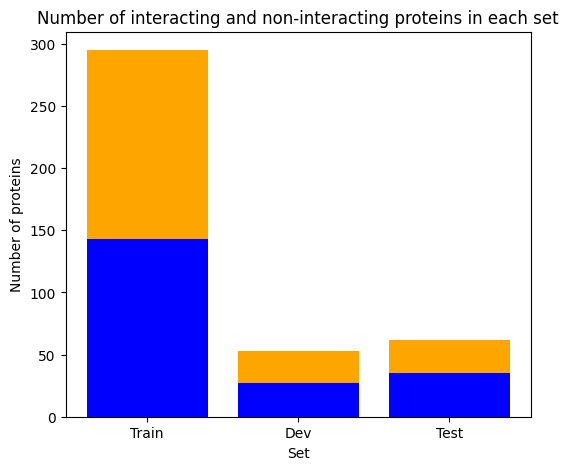

In [891]:
# Define the sizes for train, dev, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X_dataset, Y_dataset, test_size=0.15)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train_temp, Y_train_temp, test_size=0.15) 

# Plot how many interacting and non-interacting proteins are in each set, but with different colors
plt.figure(figsize=(6, 5))
plt.title("Number of interacting and non-interacting proteins in each set")
plt.xlabel("Set")
plt.ylabel("Number of proteins")
plt.bar(["Train", "Dev", "Test"], [len(Y_train[Y_train == 1]), len(Y_dev[Y_dev == 1]), len(Y_test[Y_test == 1])], color="blue")
plt.bar(["Train", "Dev", "Test"], [len(Y_train[Y_train == 0]), len(Y_dev[Y_dev == 0]), len(Y_test[Y_test == 0])], bottom=[len(Y_train[Y_train == 1]), len(Y_dev[Y_dev == 1]), len(Y_test[Y_test == 1])], color="orange")
plt.show()


In [892]:
# dropout_prob = 0.2
learning_rate = 0.001
weight_decay = 0.0001
epochs = 500

In [893]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.accuracy = BinaryAccuracy()
        self.f1_score = BinaryF1Score()
        self.precision = BinaryPrecision()
        self.recall = BinaryRecall()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.ReLU(),
            # nn.Dropout(p=dropout_prob),
            nn.Linear(in_features=hidden_dim, out_features=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.linear_layer_stack(x)
        return x

In [894]:
X_train = X_train.float().to(device)
X_dev = X_dev.float().to(device)
X_test = X_test.float().to(device)
Y_train = Y_train.float().to(device)
Y_dev = Y_dev.float().to(device)
Y_test = Y_test.float().to(device)

In [895]:
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = NN(
    input_dim=X_dataset.shape[1],
    hidden_dim=64
).to(device)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

In [896]:
train_metrics = {'losses': [], 'accs': [], 'f1_scores': [], 'precision': [], 'recall': []}
dev_metrics = {'losses': [], 'accs': [], 'f1_scores': [], 'precision': [], 'recall': []}
test_metrics = {'losses': [], 'accs': [], 'f1_scores': [], 'precision': [], 'recall': []}

def calculate_metrics(logits, labels, set_type):
    pred = torch.round(torch.sigmoid(logits))
    loss = loss_fn(logits, labels)
    acc = model_0.accuracy(pred, labels)
    f1 = model_0.f1_score(pred, labels)
    prec = model_0.precision(pred, labels)
    rec = model_0.recall(pred, labels)
    
    if set_type == 'train':
        train_metrics['losses'].append(loss)
        train_metrics['accs'].append(acc)
        train_metrics['f1_scores'].append(f1)
        train_metrics['precision'].append(prec)
        train_metrics['recall'].append(rec)
    elif set_type == 'dev':
        dev_metrics['losses'].append(loss)
        dev_metrics['accs'].append(acc)
        dev_metrics['f1_scores'].append(f1)
        dev_metrics['precision'].append(prec)
        dev_metrics['recall'].append(rec)
    elif set_type == 'test':
        test_metrics['losses'].append(loss)
        test_metrics['accs'].append(acc)
        test_metrics['f1_scores'].append(f1)
        test_metrics['precision'].append(prec)
        test_metrics['recall'].append(rec)
        
    return loss, acc, f1, prec, rec

# Build training and eval loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    Y_logits = model_0(X_train).squeeze()
    Y_pred = torch.round(torch.sigmoid(Y_logits))

    # 2. Loss/metrics
    loss, acc, f1, prec, rec = calculate_metrics(Y_logits, Y_train, 'train')

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation, calculating the gradients)
    loss.backward()

    # 5. optimizer step (update the params)
    optimizer.step()

    ### Evaluation on dev set
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass on dev set
        dev_logits = model_0(X_dev).squeeze()
        dev_pred = torch.round(torch.sigmoid(dev_logits))
        
        # 2. Calculate dev set metrics
        dev_loss, dev_acc, dev_f1, dev_prec, dev_rec = calculate_metrics(dev_logits, Y_dev, 'dev')

        # 3. Forward pass on test set
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 4. Calculate test set metrics
        test_loss, test_acc, test_f1, test_prec, test_rec = calculate_metrics(test_logits, Y_test, 'test')

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {(acc * 100):.2f}% | Dev loss: {test_loss:.5f}, Dev acc: {(test_acc * 100):.2f}%")

Epoch: 0 | Loss: 0.69652, Acc: 48.47% | Dev loss: 0.68858, Dev acc: 56.45%
Epoch: 10 | Loss: 0.67814, Acc: 58.31% | Dev loss: 0.66747, Dev acc: 59.68%
Epoch: 20 | Loss: 0.66497, Acc: 63.39% | Dev loss: 0.64703, Dev acc: 61.29%
Epoch: 30 | Loss: 0.65194, Acc: 65.76% | Dev loss: 0.63157, Dev acc: 61.29%
Epoch: 40 | Loss: 0.63768, Acc: 68.47% | Dev loss: 0.62088, Dev acc: 64.52%
Epoch: 50 | Loss: 0.62343, Acc: 71.53% | Dev loss: 0.61190, Dev acc: 69.35%
Epoch: 60 | Loss: 0.60883, Acc: 73.90% | Dev loss: 0.60588, Dev acc: 67.74%
Epoch: 70 | Loss: 0.59406, Acc: 75.25% | Dev loss: 0.60060, Dev acc: 67.74%
Epoch: 80 | Loss: 0.57926, Acc: 74.58% | Dev loss: 0.59840, Dev acc: 69.35%
Epoch: 90 | Loss: 0.56564, Acc: 74.92% | Dev loss: 0.59660, Dev acc: 69.35%
Epoch: 100 | Loss: 0.55227, Acc: 76.27% | Dev loss: 0.59534, Dev acc: 67.74%
Epoch: 110 | Loss: 0.53891, Acc: 77.97% | Dev loss: 0.59418, Dev acc: 67.74%
Epoch: 120 | Loss: 0.52599, Acc: 76.27% | Dev loss: 0.59424, Dev acc: 69.35%
Epoch: 130

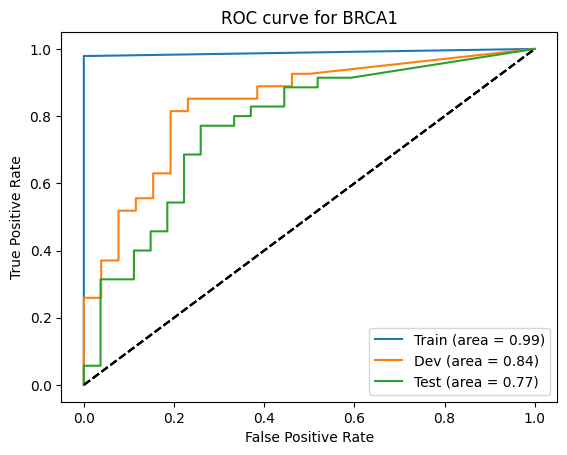

In [902]:
# Calculate ROC curve metrics
def calculate_roc_curve_metrics(model, X, Y):
  logits = model(X).squeeze()
  pred = torch.sigmoid(logits)
  fpr, tpr, _ = roc_curve(Y.detach().cpu().numpy(), pred.detach().cpu().numpy())
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, roc_auc

# Calculate ROC curve metrics for train, dev, and test sets
train_fpr, train_tpr, train_roc_auc = calculate_roc_curve_metrics(model_0, X_train, Y_train)
dev_fpr, dev_tpr, dev_roc_auc = calculate_roc_curve_metrics(model_0, X_dev, Y_dev)
test_fpr, test_tpr, test_roc_auc = calculate_roc_curve_metrics(model_0, X_test, Y_test)

def plot_roc_curve(fpr, tpr, roc_auc, label):
  plt.title(f'ROC curve for {protein_of_interest}')
  plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
    
# Plot ROC curve for train, dev, and test sets
plot_roc_curve(train_fpr, train_tpr, train_roc_auc, "Train")
plot_roc_curve(dev_fpr, dev_tpr, dev_roc_auc, "Dev")
plot_roc_curve(test_fpr, test_tpr, test_roc_auc, "Test")


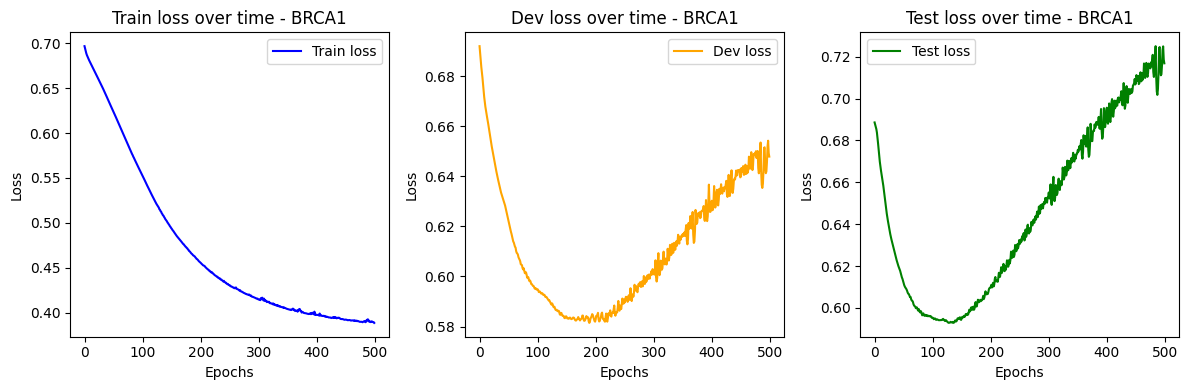

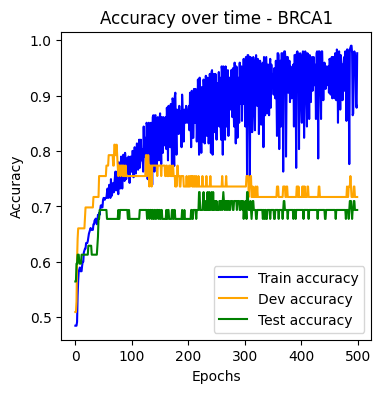

In [898]:
train_losses = [loss.item() for loss in train_metrics['losses']]
dev_losses = [loss.item() for loss in dev_metrics['losses']]
test_losses = [loss.item() for loss in test_metrics['losses']]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axs[0].plot(train_losses, label="Train loss", color='blue')
axs[0].legend()
axs[0].set_title(f"Train loss over time - {protein_of_interest}")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(dev_losses, label="Dev loss", color='orange')
axs[1].legend()
axs[1].set_title(f"Dev loss over time - {protein_of_interest}")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")

axs[2].plot(test_losses, label="Test loss", color='green')
axs[2].legend()
axs[2].set_title(f"Test loss over time - {protein_of_interest}")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")

plt.tight_layout()
plt.show()

# Visualize accuracy
plt.figure(figsize=(4, 4))
plt.plot(train_metrics['accs'], label="Train accuracy", color='blue')
plt.plot(dev_metrics['accs'], label="Dev accuracy", color='orange')
plt.plot(test_metrics['accs'], label="Test accuracy", color='green')
plt.legend()
plt.title(f"Accuracy over time - {protein_of_interest}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

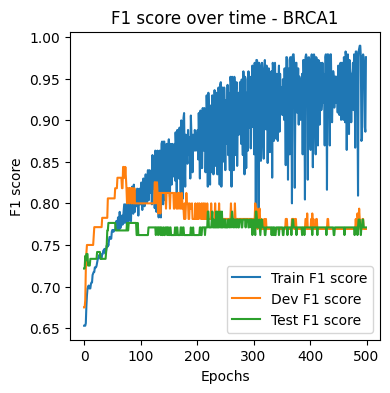

In [899]:
# Plot the F1 scores
train_f1_scores = [f1.item() for f1 in train_metrics['f1_scores']]
dev_f1_scores = [f1.item() for f1 in dev_metrics['f1_scores']]
test_f1_scores = [f1.item() for f1 in test_metrics['f1_scores']]

plt.figure(figsize=(4, 4))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(dev_f1_scores, label="Dev F1 score")
plt.plot(test_f1_scores, label="Test F1 score")
plt.legend()
plt.title(f"F1 score over time - {protein_of_interest}")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.show()

Text(0, 0.5, 'Recall')

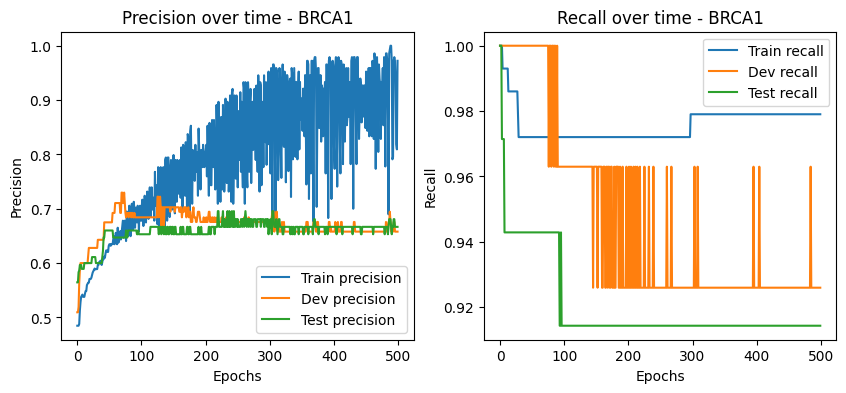

In [900]:
# Plot precision & recall side by side
train_precision = [prec.item() for prec in train_metrics['precision']]
dev_precision = [prec.item() for prec in dev_metrics['precision']]
test_precision = [prec.item() for prec in test_metrics['precision']]
train_recall = [rec.item() for rec in train_metrics['recall']]
dev_recall = [rec.item() for rec in dev_metrics['recall']]
test_recall = [rec.item() for rec in test_metrics['recall']]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(train_precision, label="Train precision")
axs[0].plot(dev_precision, label="Dev precision")
axs[0].plot(test_precision, label="Test precision")
axs[0].legend()
axs[0].set_title(f"Precision over time - {protein_of_interest}")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Precision")

axs[1].plot(train_recall, label="Train recall")
axs[1].plot(dev_recall, label="Dev recall")
axs[1].plot(test_recall, label="Test recall")
axs[1].legend()
axs[1].set_title(f"Recall over time - {protein_of_interest}")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")

